In [ ]:
# %load /home/feng/examples/1008__test__macs2.sh
source /home/feng/envs/pipe/bin/activate

### Download test Data
bash test__data.sh

### Configure $GSIZE and .../genome.fa
source config_Ath_TAIR10.sh
export CDS=/home/feng/ref/Arabidopsis_thaliana_TAIR10/Annotation/genes.gtf.cds

### Run pipeline
pipeline_macs2.sh test.bam -c test__input.bam

####### OP1: per-chip operation
### find peaks near a promoter using .gtf.cds
### Help: filterByCDS.py -h
filterByCDS.py test_peaks.narrowPeak -g $GSIZE -c $CDS

### Using pandas for now, potentially reimplement using 'bedtools groupby'
firstByKey.py type\=closest_bed\=test_peaks_radius\=1_feat\=genes.gtf.cds.tsv


####### OP2: write a summary html
### taking multiple .narrowPeak if desired
### Help: chipSummary.py -h
chipSummary.py --ref $CDS test_peaks.narrowPeak



In [1]:
#!/usr/bin/env python2
import matplotlib as mpl
mpl.use('agg')
import pymisca.util as pyutil
import synotil.CountMatrix as scount
# import synotil.PanelPlot as spanel
import synotil.util as sutil
import synotil.filterByCDS
# spanel.plt.ioff()
import time

sutil.extract_peak??

is in ipython: 1 


[WARN] pymisca.vis_util cannot find network
[WARN] Cannot find file:key.gene
[WARN] pymisca.vis_util cannot find network


is in ipython: 1 


In [19]:
%%writefile chipShot.py
# %load chipShot.py
#!/usr/bin/env python2
import matplotlib as mpl
mpl.use('agg')
import pymisca.util as pyutil
import synotil.CountMatrix as scount
# import synotil.PanelPlot as spanel
import synotil.util as sutil
import synotil.filterByCDS
import synotil.dio as sdio
import synotil.jobs as sjob
# spanel.plt.ioff()
import time
stderrLine = lambda x:pyutil.sys.stderr.write(x+'\n')


def query__gtf(gtf,accs):
    val = gtf[gtf.columns[-1]]
    qres = val.str.contains('|'.join(accs))
    res =  gtf.reindex(gtf.index[qres])
    return res

def prepare_chipTrack(x,vlim = None,**kwargs):
    ind  = x.columns
    x.columns = x.columns.droplevel(0) 
    x.name = ind.levels[0][0]
    y  = scount.countMatrix(x,look='fill',name = x.name,vlim=vlim,**kwargs) 
    
    return y
# reload(pybio)
# reload(spanel)
# figsize = 
# def worker__drawPeak(peakAcc,DIR=None,drawPeak=None):
#     ofname = '%s/%s.svg'%(DIR,peakAcc)
#     fig = drawPeak(peakAcc)
#     fig.savefig(ofname)
#     return ofname

def worker__drawPeak(peakAcc,
                     df_near, 
                     gtfs,
                     chipTracks,
                     radius,
                     figsize=None,
                     DIR=None,
                     debug=0,
                     ylim = None,
                    ):
    '''For parallel running'''
    import synotil.PanelPlot as spanel
#     def worker():
    if 1:
        df_feats = df_near.query('acc=="%s"'%peakAcc)
        if df_feats.empty:
            start = 0
            end = radius * 2
#             return None
        else:
            first = df_feats.iloc[0]
            start= first.start - radius
            end = first.end + radius

        def prepare__gtf(gtf,):
            if df_feats.empty:
                return None
            else:
                gcurr = query__gtf(gtf, accs = df_feats.feat_acc.values)
                #### shift to appropriate coordinate for gtf
                gcurr[3]  += -start   
                gcurr[4]  = gcurr[4] -start 
            #     gcurr = gcurr.reindex(gcurr.index[(gcurr[3]>0) & (gcurr[4]>0)])
                gcurr = gcurr.reindex(gcurr.index[(gcurr[4]>0)])
                return gcurr

        tracks = chipTracks +[ x for x in map(prepare__gtf,gtfs) if x is not None]
        if debug:
            val = prepare__gtf(gtfs[0])
            print('[GCURR]')
            if val is None:
                print (val)
            else:
                print(val.look)
                print (pyutil.mat2str(val.values[:,:8]))
        
        # gcurr = gcurr.reindex(gcurr.index[(gcurr[3]>0) & (gcurr[4]>0)])
        span = 2*radius
        title = '''\
{peakAcc}\nstart={start}  end={end}, span={span}
ylim={ylim}
'''.format(**locals())
        ofname = '%s/%s.svg'%(DIR,peakAcc)
        while True:
            try:
                pp = spanel.panelPlot(tracks ,
                                      index=[peakAcc],
                                      figsize=figsize,
                                      debug=debug, 
                                      xlim = [0,radius * 2],
                                      show_axa=False, 
            #                           vlim = ylim,
                                         title=title)
                fig = pp.render(silent=1);
                fig.savefig(ofname)
                break
            except RuntimeError as e:
                print ('[WARN] caught exception when plotting:%s'%e)
                time.sleep(0.05)
#         fig = pp.render(silent=1);

        print('[MSG] plotting to: %s' % ofname)

        return ofname
    
def worker__fluff(rec,):
    rec = pyutil.util_obj(**rec)
    DIR = getattr(rec,'DIR','.')
    ext = getattr(rec,'ext','svg')
    labels = getattr(rec,'labels',None)
#     ofname  = rec.acc + '.svg'
    ofname  = '%s/%s.%s' % (DIR,rec.acc,ext) 
    interval = rec.interval
    tracks = rec.tracks
    annotation = rec.annotation
#             ofname   = bed.acc[i]  + '.svg'
#             interval = bed.interval[i]
    ofname   = sjob.fig__fluffProfile(
                        interval,
                        tracks, 
                        ofname = ofname,
                        annotation = annotation,
                        labels = labels)
    return ofname        
# worker = pyutil.functools.partial(sjob.fig__fluffyProfile,
# #                                          interval = 
#                                  )            
def main(
    #### necessary
    bedFile = None,
    bwFiles = None,
    ####  
    DIR=None,
    figsize=[14,14],
    debug = 0,
    ylim = [0,10],
    radius = 2000,
    stepSize = 10,
    NCORE= 4,
    silent = 0,
    gtfFile = None,
    cdsFile = None,
    annotation = None,
    GSIZE= None,
    center_summit = 0,
    trackNames = None,
    backend = 'fluff',
    ext = 'png',
    **kwargs
):
#     vlim = ylim
    figsize= map(int,figsize)
    # for peakAcc in df_near.acc.unique()[:1]:   

    prefix = 'PROG=chipShots_bedFile='
#     bname  = pyutil.basename(bedFile)
    bname = pyutil.os.path.basename(bedFile)
    odname = prefix + bname 
    if DIR=='inplace':
        DIR = pyutil.os.path.dirname(bedFile) + odname
    elif DIR is None:
        DIR = odname
    pyutil.shellexec('mkdir -p %s' % DIR,silent=silent)
    DIR = pyutil.os.path.abspath(DIR)
#     odname = pyutil.ospath

    if cdsFile is None:
        cdsFile = gtfFile + '.cds'
    if backend == 'synotil':
        # nearFile = './DE2017/type=closest_bed=lux22_radius=1_feat=genes.gtf.cds.tsv'
        # import synotil.filterByCDS
        nearFile = synotil.filterByCDS.main(
            peakFile=bedFile,
            cdsFile=cdsFile,
            downStream=radius,
            upStream=radius,
            peakRadius = 1,
            GSIZE=GSIZE,
            center_summit=center_summit,
            )
        df_near = pyutil.readData(nearFile,)

        stderrLine('[MSG]Loading bed intervals from bigwig tracks....')

        chipTracks = sutil.extract_bigwig_multiple(fnames=bwFiles,
                                                  bedFile=bedFile,
                                                  radius=radius,
                                                  stepSize=stepSize,
                                                   callback=None,
                                                   outIndex=trackNames,

    #                                               callback=callback,
                                                   center_summit=center_summit,
                                                   shift = 0, #### use positive coordinate
                                                   stranded=False,
                                                   NCORE=NCORE)
        if ylim is None:
            ylim = pyutil.span(pyutil.np.hstack([x.values.flat for x in chipTracks]),99)
            ylim = list(ylim)
            ylim[0] = 0.
        callback = lambda x:[prepare_chipTrack(ele,
                                               vlim=ylim) 
                             for ele in x] 
        chipTracks = callback(chipTracks)

        if debug:
            stderrLine(chipTracks[0].columns)

        gtf = pyutil.readData(gtfFile,ext='tsv',header=None,guess_index=0)
        gtf = scount.countMatrix(gtf,look='gtf')
        gtfs= [gtf]


    #     uniqPeak = df_near.acc.unique()
    #     bedDF = pyutil.readData(bedFile,header=None,guess_index=0)
    #     bedDF.columns = sutil.bedHeader[:len(bedDF.columns)]
        bedDF = sutil.extract_peak(bedFile)
    #     uniqPeak
    #     uniqPeak = bedDF[bedDF.columns]

        worker=  pyutil.functools.partial(worker__drawPeak, 
                                          DIR=DIR,
                                          chipTracks = chipTracks,
                                          df_near=df_near,
                                          gtfs = gtfs,
                                          radius = radius,
                                          figsize=figsize,
                                          ylim = ylim,
                                          debug=debug,)

        ofnames = pyutil.mp_map(worker, bedDF.acc, n_cpu=NCORE,)
    elif backend=='fluff':
        bedDF = sdio.extract_peak(bedFile)
        
        argDF = bedDF.copy()
        argDF = sdio.bed__addCol__interval(argDF)
        tracks = list(bwFiles)
        argDF['tracks'] = [tracks ] * len(bedDF)
        argDF['annotation'] = annotation
        argDF['DIR'] = DIR
        argDF['ext'] = ext
        if trackNames is not None:
            argDF['labels'] = [list(trackNames)]  * len(bedDF)
            
        ofnames = pyutil.mp_map(
#         ofnames = map(
            worker__fluff, 
            ( vars(x) for x in argDF.itertuples() ), 
            n_cpu=NCORE,
         )
#         ofnames = 
        
    
    bedDF['img'] = ofnames
    indexFile = '%s/%s.index.tsv'%(DIR,bname)
    pyutil.to_tsv(bedDF,indexFile)
    indexFile = '%s/figureIndex.tsv'%(DIR)
    pyutil.to_tsv(bedDF,indexFile)
    
    try:
        import synotil.shot2html as shot2html
        htmlFile = shot2html.shot2html(indexFile,localPath=True)
    except Exception as e:
        stderrLine ('[WARN]:cannot produce html :%s'%e)
        htmlFile = None
#     print ('[OUTPUT]:',)
#     print ('html:',htmlFile)
#     print ('index:',indexFile)
    print (indexFile) 
    print (htmlFile)
    return (indexFile,htmlFile)


testDict = {
    'bedFile': './DE2017/lux22_radius=1.tsv',
    'bwFiles': ['/home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S5/EC-1167_S5_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw',
     '/home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S6/EC-1167_S6_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw',
     '/home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S7/EC-1167_S7_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw',
     '/home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S8/EC-1167_S8_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw'],
    'gtfFile': '/home/feng/ref/Arabidopsis_thaliana_TAIR10/annotation/genes.gtf',
    'GSIZE': '/home/feng/ref/Arabidopsis_thaliana_TAIR10/genome.sizes',
    'NCORE' :10,
    'radius':2000,
}


import argparse

parser= argparse.ArgumentParser()
parser.add_argument('-v','--silent',default=0,type = int)

parser.add_argument('-b','--bedFile',default=None,)
parser.add_argument('bwFiles',nargs='+')
parser.add_argument('-r','--radius',default=2000, type=int,)

# parser.add_argument('-c','--cdsFile',default=pyutil.os.environ.get('GTF','none')+'.cds')
parser.add_argument('-a','--gtfFile',
                    default=pyutil.os.environ.get('GTF','none')+'.cds')
parser.add_argument('-c','--cdsFile',
                    default=None)

parser.add_argument('-g','--GSIZE',
                    default=pyutil.os.environ.get('GSIZE',None))
parser.add_argument('-o','--DIR',default=None)
parser.add_argument('-j','--NCORE',
                    default=pyutil.os.environ.get(4,None),type=int)
parser.add_argument('-s','--center_summit',
                    default=0, type=int)
parser.add_argument('-d','--debug',
                    default=0, type=int)
parser.add_argument('-f','--figsize',
                    default=[14,14], type=int,nargs=2)
# parser.add_argument('-y','--ylim',
#                     default=[0., 10.], type=float,nargs=2)
parser.add_argument('-y','--ylim',
                    default=None, type=float,nargs=2)

defaults = {act.dest:act.default for act in parser._actions}
for key in ['bedFile','bwFiles']:
    defaults.pop(key)

main = pyutil.functools.partial(main,**defaults)
# argparser
if __name__=='__main__':
    args = parser.parse_args()
    pars = vars(args)
    assert pars['bedFile'] is not None
    print (pyutil.ppJson(pars))
    main(**pars)
    stderrLine('[Done]')

Overwriting chipShot.py


In [74]:
for act in parser._actions:
    print act.dest,act.default,type(act.default)

help ==SUPPRESS== <type 'str'>
verbosilecentse 0 <type 'int'>
bedFile None <type 'NoneType'>
bwFiles None <type 'NoneType'>
radius 2000 <type 'int'>
gtfFile none.cds <type 'str'>
cdsFile None <type 'NoneType'>
GSIZE None <type 'NoneType'>
DIR None <type 'NoneType'>
NCORE None <type 'NoneType'>
center_summit 0 <type 'int'>
debug 0 <type 'int'>
figsize [14, 14] <type 'list'>
ylim None <type 'NoneType'>


In [65]:
args  =parser.parse_known_args('')[0]
dict(args._get_kwargs())


usage: ipykernel_launcher.py [-h] [-v VERBOSILECENTSE] [-b BEDFILE]
                             [-r RADIUS] [-a GTFFILE] [-c CDSFILE] [-g GSIZE]
                             [-o DIR] [-j NCORE] [-s CENTER_SUMMIT] [-d DEBUG]
                             [-f FIGSIZE FIGSIZE] [-y YLIM YLIM]
                             bwFiles [bwFiles ...]
ipykernel_launcher.py: error: too few arguments


SystemExit: 2

In [22]:
# parser.get_default()
# parser.parse_args('')

usage: ipykernel_launcher.py [-h] [-v VERBOSILECENTSE] [-b BEDFILE]
                             [-r RADIUS]
                             bwFiles [bwFiles ...]
ipykernel_launcher.py: error: too few arguments


SystemExit: 2

In [62]:

import argparse

import pymisca.util as pyutil
parser= argparse.ArgumentParser()
parser.add_argument('-v','--verbosilecentse',default=0,type = int)

parser.add_argument('-b','--bedFile',default=None,)
parser.add_argument('bwFiles',nargs='+')
parser.add_argument('-r','--radius',default=2000, type=int,)

# parser.add_argument('-c','--cdsFile',default=pyutil.os.environ.get('GTF','none')+'.cds')
parser.add_argument('-a','--gtfFile',
                    default=pyutil.os.environ.get('GTF','none')+'.cds')
parser.add_argument('-c','--cdsFile',
                    default=None)

parser.add_argument('-g','--GSIZE',
                    default=pyutil.os.environ.get('GSIZE',None))
parser.add_argument('-o','--DIR',default=None)
parser.add_argument('-j','--NCORE',
                    default=pyutil.os.environ.get(4,None),type=int)
parser.add_argument('-s','--center_summit',
                    default=0, type=int)
parser.add_argument('-d','--debug',
                    default=0, type=int)
parser.add_argument('-f','--figsize',
                    default=[14,14], type=int,nargs=2)
# parser.add_argument('-y','--ylim',
#                     default=[0., 10.], type=float,nargs=2)
parser.add_argument('-y','--ylim',
                    default=None, type=float,nargs=2)

is in ipython: 1 
[WARN]No module named jinja2_util


_StoreAction(option_strings=['-y', '--ylim'], dest='ylim', nargs=2, const=None, default=None, type=<type 'float'>, choices=None, help=None, metavar=None)

In [49]:
?synotil.filterByCDS.main

In [46]:
%%time
import chipShot as mod;reload(mod)
# mod = chipShot

mod.testDict['bwFlat'] = ' '.join(mod.testDict['bwFiles'])
cmd = '''./chipShot.py -g {GSIZE} -j {NCORE} -a {gtfFile} -b {bedFile} -r {radius} {bwFlat}
'''.format(**mod.testDict)

print cmd
# ! {cmd}
# pyutil.shellexec(cmd,)

./chipShot.py -g /home/feng/ref/Arabidopsis_thaliana_TAIR10/genome.sizes -j 10 -a /home/feng/ref/Arabidopsis_thaliana_TAIR10/annotation/genes.gtf -b ./DE2017/lux22_radius=1.tsv -r 2000 /home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S5/EC-1167_S5_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw /home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S6/EC-1167_S6_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw /home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S7/EC-1167_S7_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw /home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S8/EC-1167_S8_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.53 ms


In [61]:
mod.testDict

{'GSIZE': '/home/feng/ref/Arabidopsis_thaliana_TAIR10/genome.sizes',
 'NCORE': 10,
 'bedFile': './DE2017/lux22_radius=1.tsv',
 'bwFiles': ['/home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S5/EC-1167_S5_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw',
  '/home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S6/EC-1167_S6_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw',
  '/home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S7/EC-1167_S7_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw',
  '/home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S8/EC-1167_S8_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw'],
 'bwFlat': '/home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S5/EC-1167_S5_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw /home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S6/EC-1167_S6_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw /home/feng/envs/Fig_Brachy/DE201

In [69]:
reload(synotil.filterByCDS)

<module 'synotil.filterByCDS' from '/home/feng/.local/lib/python2.7/site-packages/synotil/filterByCDS.pyc'>

In [70]:
%%time
%pdb 0

import chipShot as mod;reload(mod)
# mod = chipShot
mod.testDict['NCORE'] = 3
indexFile = mod.main(**mod.testDict)
print 'Done'
!head {indexFile}

Automatic pdb calling has been turned OFF
mkdir -p PROG=chipShots_bedFile=lux22_radius=1.tsv


[tmp]:lux22_radius=1_radius=1.tsv,lc=42
[output]:type=closest_bed=lux22_radius=1_radius=1_feat=genes.gtf.cds.tsv,lc=53


type=closest_bed=lux22_radius=1_radius=1_feat=genes.gtf.cds.tsv
[MSG]Loading bed intervals from bigwig tracks....
[L] 42


PicklingError: Can't pickle <type 'function'>: attribute lookup __builtin__.function failed

In [350]:
%pdb 1

Automatic pdb calling has been turned ON


In [29]:
! head -n 2 {mod.testDict['bedFile']} > test__2peak__Ath.bed

[WARN] Cannot find file:key.gene
[WARN] pymisca.vis_util cannot find network
[WARN] pymisca.vis_util cannot find network


is in ipython: 1 
is in ipython: 1 


[WARN] pymisca.vis_util cannot find network
[WARN] pymisca.vis_util cannot find network


is in ipython: 1 
chipShot.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/feng/.local/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/feng/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/feng/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/feng/.local/lib/python2.7/site-packages/

mkdir -p PROG=chipShots_bedFile=test__2peak__Ath.bed


[tmp]:test__2peak__Ath_radius=1.tsv,lc=2
[output]:type=closest_bed=test__2peak__Ath_radius=1_feat=genes.gtf.cds.tsv,lc=4


type=closest_bed=test__2peak__Ath_radius=1_feat=genes.gtf.cds.tsv
[MSG]Loading bed intervals from bigwig tracks....
[L] 2
[L]= 400
[L]= 400
[L]= 400
[L]= 400


/home/feng/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  del sys.path[0]


[MSG] plotting to: /home/feng/envs/Fig_Brachy/PROG=chipShots_bedFile=test__2peak__Ath.bed/LUX_predictd_p0.05_peak_133.svg
[MSG] plotting to: /home/feng/envs/Fig_Brachy/PROG=chipShots_bedFile=test__2peak__Ath.bed/LUX_predictd_p0.05_peak_445.svg
Done
1	1829942	1829944	LUX_predictd_p0.05_peak_133	106	.	3.03647	10.60354	7.59973	1829943	/home/feng/envs/Fig_Brachy/PROG=chipShots_bedFile=test__2peak__Ath.bed/LUX_predictd_p0.05_peak_133.svg
1	7025100	7025102	LUX_predictd_p0.05_peak_445	232	.	4.74602	23.25812	19.97789	7025101	/home/feng/envs/Fig_Brachy/PROG=chipShots_bedFile=test__2peak__Ath.bed/LUX_predictd_p0.05_peak_445.svg


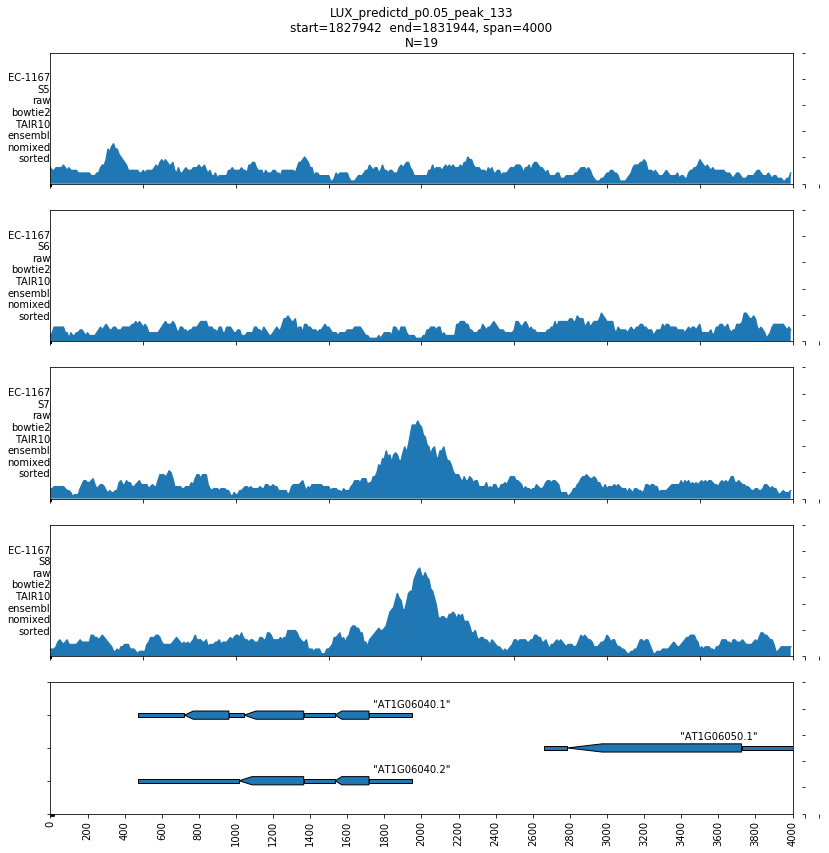

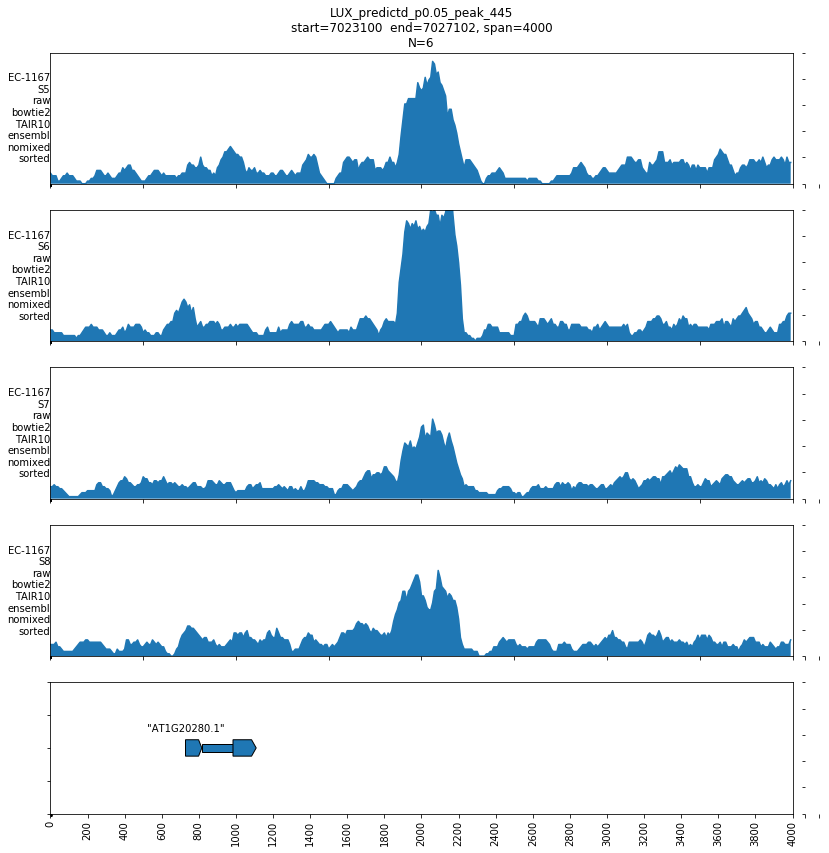

In [43]:
execfile('/home/feng/meta/header_0903.py')
import pymisca.bio as pybio
reload(scount)
reload(spanel)
reload(pyvis)
reload(pybio)
import chipShot as mod;reload(mod)
# mod = chipShot
mod.testDict['NCORE'] = 1
dct = mod.testDict.copy()
! head -n 2 {mod.testDict['bedFile']} > test__2peak__Ath.bed
dct['bedFile'] = "test__2peak__Ath.bed"
indexFile = mod.main(**dct)
print 'Done'
!head {indexFile}

In [366]:
! grep /home/feng/ref/Arabidopsis_thaliana_TAIR10/annotation/genes.gtf -e AT5G17460.1 > AT5G17460.gtf

In [369]:
# pyutil.read_
pybio.read_gtf('AT5G17460.gtf')[0].features

[SeqFeature(FeatureLocation(ExactPosition(5757097), ExactPosition(5759795), strand=-1), type='inferred_parent', id='AT5G17460.1')]

In [10]:
! grep /home/feng/ref/Arabidopsis_thaliana_TAIR10/annotation/genes.gtf -e AT1G06460.1 > AT1G06460.gtf
gtf  =pybio.read_gtf('AT1G06460.gtf')

[WARN] pymisca.vis_util cannot find network
('[strand]', -1)
('adding intron', ExactPosition(1969561), ExactPosition(1969414))
('adding exon', ExactPosition(1969414), ExactPosition(1969309))
('adding intron', ExactPosition(1969309), ExactPosition(1968906))
('adding exon', ExactPosition(1968906), ExactPosition(1968783))
('adding intron', ExactPosition(1968783), ExactPosition(1968628))
('adding exon', ExactPosition(1968628), ExactPosition(1968511))
('adding intron', ExactPosition(1968511), ExactPosition(1968421))
('adding exon', ExactPosition(1968421), ExactPosition(1968225))
('adding intron', ExactPosition(1968225), ExactPosition(1967978))
('adding exon', ExactPosition(1967978), ExactPosition(1967863))
('adding intron', ExactPosition(1967863), ExactPosition(1967767))
('adding exon', ExactPosition(1967767), ExactPosition(1967602))
('adding intron', ExactPosition(1967602), ExactPosition(1967344))
('adding exon', ExactPosition(1967344), ExactPosition(1967310))
('adding intron', ExactPositi

(ExactPosition(1967086), ExactPosition(1969561))

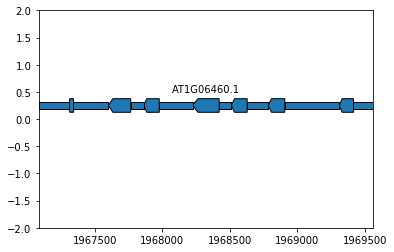

In [20]:
reload(pyvis)
reload(pybio)
plt.xlim(pybio.add_transcript(gtf[0].features[0],debug=1)[0])

In [14]:
g = gtf[0].features[0]

In [18]:
f = g.sub_features[0]
# f.location.nofuzzy_sta

(1967086, ExactPosition(1967086))

In [331]:
mod.testDict

{'GSIZE': '/home/feng/ref/Arabidopsis_thaliana_TAIR10/genome.sizes',
 'NCORE': 1,
 'bedFile': './DE2017/lux22_radius=1.tsv',
 'bwFiles': ['/home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S5/EC-1167_S5_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw',
  '/home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S6/EC-1167_S6_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw',
  '/home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S7/EC-1167_S7_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw',
  '/home/feng/envs/Fig_Brachy/DE2017/bw/122C/EC-1167_S8/EC-1167_S8_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm.bw'],
 'gtfFile': '/home/feng/ref/Arabidopsis_thaliana_TAIR10/annotation/genes.gtf',
 'radius': 2000}

In [49]:
!chmod +x  chipShot.py
!ln chipShot.py /home/feng/repos/BrachyPhoton/synotil/
!ln chipShot.py /home/feng/repos/synotil/src/

In [65]:
figs =  pyutil.mp_map(drawPeak,uniqPeak[:5],n_cpu=5,)
# figs = map(drawPeak,)

NameError: name 'drawPeak' is not defined

In [ ]:
[fig.show() for fig in figs]

In [374]:
pyutil.MDFile('temp.svg')

[temp.svg](temp.svg)

In [281]:
%%bash
GTF=/home/feng/ref/Arabidopsis_thaliana_TAIR10/annotation/genes.gtf
echo $GTF
grep $GTF -e  "AT4G16" | tee AT4G167xx.gtf | head

/home/feng/ref/Arabidopsis_thaliana_TAIR10/annotation/genes.gtf
4	protein_coding	exon	9063845	9064481	.	-	.	exon_number "1"; gene_id "AT4G16000"; gene_name "AT4G16000"; p_id "P12858"; seqedit "false"; transcript_id "AT4G16000.1"; transcript_name "AT4G16000.1"; tss_id "TSS35792";
4	protein_coding	stop_codon	9064163	9064165	.	-	0	exon_number "1"; gene_id "AT4G16000"; gene_name "AT4G16000"; p_id "P12858"; transcript_id "AT4G16000.1"; transcript_name "AT4G16000.1"; tss_id "TSS35792";
4	protein_coding	CDS	9064166	9064432	.	-	0	exon_number "1"; gene_id "AT4G16000"; gene_name "AT4G16000"; p_id "P12858"; protein_id "AT4G16000.1"; transcript_id "AT4G16000.1"; transcript_name "AT4G16000.1"; tss_id "TSS35792";
4	protein_coding	start_codon	9064430	9064432	.	-	0	exon_number "1"; gene_id "AT4G16000"; gene_name "AT4G16000"; p_id "P12858"; transcript_id "AT4G16000.1"; transcript_name "AT4G16000.1"; tss_id "TSS35792";
4	protein_coding	exon	9067830	9068512	.	+	.	exon_number "1"; gene_id "AT4G16008"; gen

In [ ]:
print 1

In [289]:
gtf =pybio.read_gtf(in_file='AT4G167xx.gtf')
# gtf[0].features[0].sub_features
print len(gtf[0].features)

170


9449113 9450743 9450601
9449450 9449290 9449450
9449852 9449553 9449852
9450200 9450120 9450200


(ExactPosition(9449113), ExactPosition(9450743))

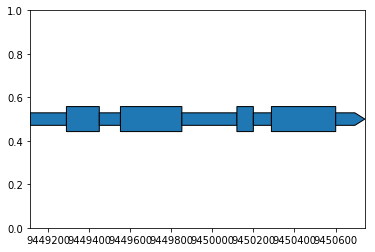

In [139]:
feats = g1.features
g = feats[0]
subfeats = g.sub_features

import pymisca.vis_util as pyvis
# def add_transcript(g,ax,ycent=0.5,ax=None,):
#     if ax is None:
#         ax = plt.gca()
ax = plt.subplot(111)
ycent = 0.5
arrowArgs = {'ycent':ycent,'ax':ax}

# start_new = g2.location.start

intronHeight = 0.25
exonHeight = 0.5

end = g.location.start

for i,f in enumerate(subfeats):
    if f.type=='CDS':
        print end,start_new,end_new
        start_new,end_new = f.location.start, f.location.end
        pyvis.add_hbox(end,start_new,height = intronHeight,**arrowArgs)
                
        pyvis.add_hbox(start_new,end_new,height = exonHeight,**arrowArgs)
        start,end = start_new,end_new
    elif i + 1 ==len(subfeats):
        start_new = g.location.end
        pyvis.add_harrow(end,start_new,height = intronHeight,**arrowArgs)
        continue
        

plt.xlim(g.location.start,g.location.end)

(ExactPosition(9449113), ExactPosition(9450743))

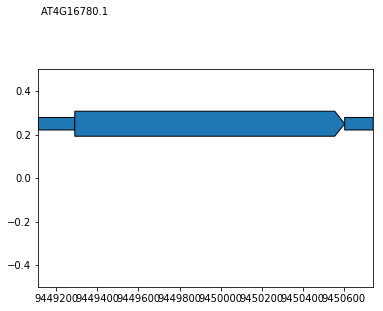

In [85]:
import pymisca.bio as pybio
plt = pyutil.plt
g = pybio.read_gtf('at5g.gtf')
res = pybio.add_transcript(g=g[0])
plt.xlim(res[0])
# g

In [66]:
! ls *.gtf

at5g.gtf


In [340]:
gcurr

,0,1,2,3,4,5,6,7,8
39389,1,protein_coding,exon,-2351,-2036,.,-,.,"exon_number ""8""; gene_id ""AT1G20270""; gene_nam..."
39390,1,protein_coding,exon,-1732,-1644,.,-,.,"exon_number ""7""; gene_id ""AT1G20270""; gene_nam..."
39391,1,protein_coding,stop_codon,-1717,-1715,.,-,0,"exon_number ""7""; gene_id ""AT1G20270""; gene_nam..."
39392,1,protein_coding,CDS,-1714,-1644,.,-,2,"exon_number ""7""; gene_id ""AT1G20270""; gene_nam..."
39393,1,protein_coding,CDS,-1542,-1355,.,-,1,"exon_number ""6""; gene_id ""AT1G20270""; gene_nam..."
39394,1,protein_coding,exon,-1542,-1355,.,-,.,"exon_number ""6""; gene_id ""AT1G20270""; gene_nam..."
39395,1,protein_coding,CDS,-1268,-1139,.,-,2,"exon_number ""5""; gene_id ""AT1G20270""; gene_nam..."
39396,1,protein_coding,exon,-1268,-1139,.,-,.,"exon_number ""5""; gene_id ""AT1G20270""; gene_nam..."
39397,1,protein_coding,CDS,-984,-887,.,-,1,"exon_number ""4""; gene_id ""AT1G20270""; gene_nam..."
39398,1,protein_coding,exon,-984,-887,.,-,.,"exon_number ""4""; gene_id ""AT1G20270""; gene_nam..."


In [101]:
# spanel.panelPlot
scount.countchipTrack.reindex(index=[peakAcc])

bwFile                       EC-1167_S5_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm  \
pos                                                                                                  0      
LUX_predictd_p0.05_peak_8244                                           1.215871                             

bwFile                                                                         \
pos                               10        20       30        40        50     
LUX_predictd_p0.05_peak_8244  1.013226  0.607935  0.40529  0.607935  0.202645   

bwFile                                                                 ...     \
pos                               60        70        80       90      ...      
LUX_predictd_p0.05_peak_8244  0.202645  0.202645  0.202645  0.40529    ...      

bwFile                       EC-1167_S8_raw_bowtie2_TAIR10_ensembl_nomixed_sorted_rmdup_picard_genomenorm  \
pos                                                                                                  1900   
LUX_predictd_p0.05_peak_8244                                           1.234842                             

bwFile                                                                         \
pos                               1910      1920     1930      1940      1950   
LUX_predictd_p0.05_peak_8244  1.234842  1.234842  0.88203  1.411248  1.058436   

bwFile                                                              
pos                              1960     1970      1980      1990  
LUX_predictd_p0.05_peak_8244  0.88203  0.88203  1.234842  1.234842  

[1 rows x 800 columns]

[WARN] pymisca.vis_util cannot find network


is in ipython: 1 


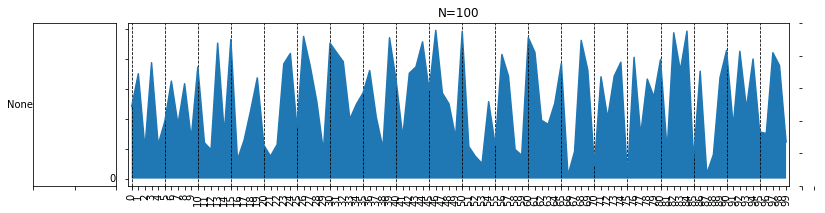

In [8]:
import synotil.PanelPlot as spanel; reload(spanel)
import synotil.CountMatrix as scount; reload(scount)
y = np.random.random((100,1))
tracks = [scount.countMatrix(y),]
spanel.panelPlot(tracks).render();
